In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from watermelon import WATERMELON
import numpy as np
import random

In [2]:
# 读取数据
root = "./"
path = 'watermelon.csv'
dataset = WATERMELON(root,path)
data = dataset.data
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
# data数据展示
data

array([[0.697, 0.46 ],
       [0.774, 0.376],
       [0.634, 0.264],
       [0.608, 0.318],
       [0.556, 0.215],
       [0.403, 0.237],
       [0.481, 0.149],
       [0.666, 0.091],
       [0.437, 0.211],
       [0.666, 0.091],
       [0.243, 0.267],
       [0.245, 0.057],
       [0.343, 0.099],
       [0.639, 0.161],
       [0.657, 0.198],
       [0.36 , 0.37 ],
       [0.593, 0.042],
       [0.719, 0.103],
       [0.359, 0.188],
       [0.339, 0.241],
       [0.282, 0.257],
       [0.748, 0.232],
       [0.714, 0.346],
       [0.483, 0.312],
       [0.478, 0.437],
       [0.525, 0.369],
       [0.751, 0.489],
       [0.532, 0.472],
       [0.473, 0.376],
       [0.725, 0.445],
       [0.446, 0.459]])

In [4]:
# 计算某一聚类中中所有样本与样本中心的的欧氏距离的平方
def distance(data, center):
    '''
    input:data:
          center:样本中心向量
          data:某一聚类中中所有样本数据集(这里也可以是单个向量)
    output:distance(float):欧氏距离平方
    '''   
    if data.shape != center.shape:
        return np.sum((data - np.tile(center, (data.shape[0], 1))) * (data - np.tile(center, (data.shape[0], 1))), axis=1)
    else:
        return np.sum((data - center) * (data - center), axis=-1)

In [5]:
class Kmeans():
    """
    Parameters:
    k: 聚类的数目，默认为2
    max_iterations: int
        最大迭代次数.
    edge: float
        判断是否收敛, 如果上一次的所有k个聚类中心与本次的所有k个聚类中心的差都小于edge,
        则说明算法已经收敛
    flag:是否采用kmeans++算法优化初始值选取
    """

    def __init__(self, k=2, max_iterations=500, edge=0.0001, flag=False):
        self.k = k
        self.max_iterations = max_iterations
        self.edge = edge
        self.ans = {}  # 分类结果
        self.cnt = 1
        self.centers = None   # 聚类中心集
        self.flag = flag     # 是否采用kmeans++算法优化

    # 从所有样本中随机选取self.k样本作为初始的聚类中心
    def init_centers(self, dataset):
        '''
       input:dataset:样本数据集
       output:centers:聚类中心的数据集
       '''
        dataset_nums = dataset.shape[0]  # 样本的数目
        centers = dataset[np.random.choice(np.arange(dataset_nums), self.k, replace=False)]   # 初始化聚类中心
        return centers
    
    
    # 优化版选取初始值（kmeans++)
    def init_centersplus(self, dataset):
        '''
        input:dataset:样本数据集
        output:centers:聚类中心的数据集
        '''
        centers = []        # 聚类中心的数据集,最后会转化为ndarray
        dataset_nums = dataset.shape[0]       # 得到数据个数
        center = dataset[np.random.choice(dataset.shape[0], 1)][0]   # 随机得到一个数据集
        centers.append(center)                      # 加到聚类中心列表中
        for i in range(self.k - 1):
            min_dist = [np.min(distance(np.array(centers, dtype=object), sing_data))  for sing_data in dataset] # 得到每一个样本到聚点中心的最短距离(这里的距离是距离的平方)
            sum_dist = sum(min_dist)  # 得到总和
            p_dist = np.array(min_dist, dtype='float') / sum_dist  # 得到每一个的概率
            index = np.random.choice(range(dataset_nums), p=p_dist.ravel())  # 按照p_dist中的概率选出新聚类中心索引
            centers.append(dataset[index])  # 加到聚类中心集中
            
        return np.array(centers, dtype=object)  # 返回初始化结果
        
    
    # 分类求在某聚类中心下每个点的分类
    def sort_class(self, centers, dataset):
        '''
        input:dataset:样本数据集
         centers:聚类中心的数据集
        output:每个样本的分类向量集
        '''
        dist = [distance(dataset, center) for center in centers]  # 用来装样本中每个点到各个聚类中心的距离
        dist_sort = np.argsort(dist, axis=0)  # 将其排序得到索引，此时dist_sort[0]就是每一个样本的分类类别
        dist_sorted = dist_sort[0]  # 每一个样本的分类类别向量集，向量里第i个元素的值j正好是第i个样本的种类类别j
        return dist_sorted


    # 计算聚类中心集合
    def cal_centers(self, dataset, dist_sorted):
        '''
        input:dataset:数据样本
        dist_sorted:每一个样本的分类类别向量集，每个向量里的值都是在dataset中的索引
        output:centers:数据样本聚类中心集合
        '''
        for i in range(self.k):
            self.ans[i] = []
        for i, vary in enumerate(dist_sorted):
            self.ans[vary].append(i)                # 更新每一个样本的分类
        
        return [np.sum(dataset[self.ans[i]], axis=0) / dataset[self.ans[i]].shape[0] for i in range(self.k) ]  # centers聚类中心集合




    # 判断是否收敛
    def judge_end(self, old_centers, centers):
        '''
        input:centers:新聚类中心集合
        old_centers:旧聚类中心集合
        output:True or False
        '''
        if self.cnt == 1:
            return False
        for old_center, center in zip(old_centers, centers):
            if np.sum(np.absolute(old_center - center)) > self.edge:
                return False
        return True



    # 预测分类聚类函数
    def predict(self, dataset):
        if self.flag == False:                   # 是否采用kmeans算法优化
            centers = self.init_centers(dataset)  # 初始化得聚类中心
        else:
            centers = self.init_centersplus(dataset)  # 初始化得聚类中心
#         print(centers)
        old_centers = None  # 旧的聚类中心
        
        while self.judge_end(old_centers, centers) == False and self.cnt <= self.max_iterations:   # 如果未到截止条件
            dist_sorted = self.sort_class(centers, dataset)    # 获得每一个样本的分类的矩阵
            old_centers = centers[::]                         # 旧的聚类中心的数组矩阵
            centers = self.cal_centers(dataset, dist_sorted)   # 新的聚类矩阵
            self.cnt += 1                               # 记录次数
        self.centers = centers                          # 记录聚类中心的数组矩阵
        return self.ans                                # 返回分类的字典，字典的键是每一类（0、1……k)，值是样本在dataset数据集中的索引

In [12]:
# 模型训练

k = int(input())
# centers = np.zeros((k, data.shape[-1]))

A = Kmeans(k=k, flag=True)
ans = A.predict(data)
centers = A.centers
print(centers)
print(A.ans)
# centers = centers / 3
# centers = A.init_centers(data)
# print(centers)
# dist_sorted = A.sort_class(centers, data)
# print(dist_sorted)
# centers = A.cal_centers(data, dist_sorted)
# print(centers)
# print(ans)     
# for k, v in ans:
#     print(k, v)


6
[array([0.66971429, 0.13114286]), array([0.30183333, 0.18483333]), array([0.7322, 0.4232]), array([0.44033333, 0.199     ]), array([0.469     , 0.41383333]), array([0.57025, 0.27725])]
{0: [7, 9, 13, 14, 16, 17, 21], 1: [10, 11, 12, 18, 19, 20], 2: [0, 1, 22, 26, 29], 3: [5, 6, 8], 4: [15, 24, 25, 27, 28, 30], 5: [2, 3, 4, 23]}


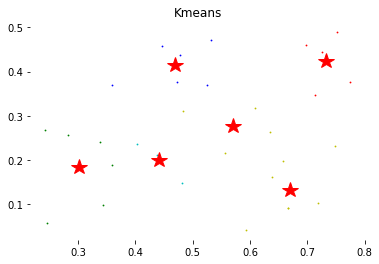

In [13]:
# 画图
# for i in data:
#     plt.plot(i[0], i[1])
color = ['y', 'g', 'r', 'c', 'b']

# for i in range(k):
#     plt.plot(data[ans[i]][:, 0], data[ans[i]][:, 0], 'oc', markersize=0.8)
# for sing_data in data:
#     plt.plot(sing_data[0], sing_data[1], 'oc', markersize=0.8, c = 'y')
for i in range(k):            # 每一类的矩阵使用不同的颜色描述
    c = color[i % 5]
    for sing_data in data[ans[i]]:
        plt.plot(sing_data[0], sing_data[1], 'oc', markersize=0.8, c = c)



for center in centers:                              # 聚类中心使用红色五角星表示
    plt.plot(center[0], center[1], 'r*', markersize=16)
plt.title('Kmeans')
plt.box(False)
# xticks([])
# yticks([])
plt.show()

50


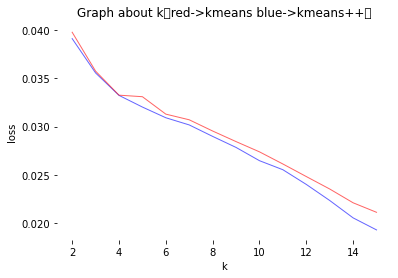

[(2, 0.03913960949004722), (3, 0.0355746407870541), (4, 0.03324269915025948), (5, 0.03203079366229477), (6, 0.030918530736257343), (7, 0.03017276264282156), (8, 0.02898211246036134), (9, 0.02783501997309937), (10, 0.026458239612649335), (11, 0.025519136214280893), (12, 0.023992055213128204), (13, 0.02232272503733381), (14, 0.02051619811563098), (15, 0.019265795183059556)]
[(2, 0.039802217119160384), (3, 0.03576233679728791), (4, 0.03326534128095157), (5, 0.03310547247185763), (6, 0.03129485063175635), (7, 0.030706840662028303), (8, 0.029540210024705166), (9, 0.02844110564188637), (10, 0.027376712251312628), (11, 0.026115408078290304), (12, 0.024809910533129198), (13, 0.0235164087335516), (14, 0.022083576031826008), (15, 0.021095213808312606)]


In [18]:
# 测试性能(不同K值)

n = int(input())      # 重复训练次数
k = 15
x = list(range(2, k + 1))
y = []
yy = []
# centers = np.zeros((k, data.shape[-1]))
for k in range(2, k + 1):
    test_sum = 0.0
    for i in range(n):
        A = Kmeans(k=k, flag=True)
        ans = A.predict(data)
        centers = A.centers
    #     print(centers)
    #     print(A.ans)



        test = 0.0
        for i in range(k):
            test += sum(distance(data[ans[i]], centers[i]))**0.5
        
        test_sum += test / data.shape[0]         # 平均距离平方和
        #     print(test)
    
    y.append(test_sum / n)            

for k in range(2, k + 1):
    test_sum = 0.0
    for i in range(n):
        A = Kmeans(k=k, flag=False)
        ans = A.predict(data)
        centers = A.centers
    #     print(centers)
    #     print(A.ans)



        test = 0.0
        for i in range(k):
            test += sum(distance(data[ans[i]], centers[i]))**0.5
        
        test_sum += test / data.shape[0]         # 平均距离平方和
        #     print(test)
    
    yy.append(test_sum / n) 
    


plt.figure('the kmeans about k')
plt.title('Graph about k red->kmeans blue->kmeans++')
plt.box(False)
ax = plt.gca()
ax.set_xlabel('k')
ax.set_ylabel('loss')  #设置x轴、y轴名称
plt.plot(x, y, color='b', linewidth=1, alpha=0.6)
plt.plot(x, yy, color='r', linewidth=1, alpha=0.6)
plt.show()
# test
print(list(zip(x, y)))
print(list(zip(x, yy)))